# Sentiment Analysis Task
spaCyTextBlob reference materials:
* https://spacy.io/universe/project/spacy-textblob
* https://spacytextblob.netlify.app/
* https://pythonology.eu/text-analysis-in-python-spacy-and-textblob/

Sentiment analysis tutorial:
* https://realpython.com/sentiment-analysis-python/

In working on this project, I prepared the task using a subset of data on my local machine, but used google colab to run the entire dataset. This resulted in some back and forth between platforms so I've coded in a location toggle to be set once at the top of the notebook.

In [1]:
# Colab toggle
# Set colab to True when running the notebook on google colab.
colab = False

In [2]:
# Additional installations for colab
if colab:
    !pip install spacytextblob
    !python -m spacy download en_core_web_md
    !pip install contractions

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.5/33.5 MB 51.6 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 345.1/345.1 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.9/114.9 kB 9.3 MB/s eta 0:00:00


In [2]:
#Import libraries
import numpy as np
import pandas as pd

# NLP
import spacy
from spacy.tokens import Doc
from spacytextblob.spacytextblob import SpacyTextBlob
import contractions

# Clustering
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from scipy.spatial.distance import squareform

# EDA
import matplotlib.pyplot as plt
import seaborn as sns

### Functions

In [3]:
def display_reviews(data, all=False):
    '''
    Function to display the dataframe with wrapped text in the review column.
    Parameters:
        data = reviews dataframe with columns name, brand, category, reviews
        all = Boolean switch to display all columns or just the reviews column
    outputs:
        displays 10 sample rows to screen
    '''
    # --- Defensive coding of inputs
    # Ensure input is a DataFrame
    try:
        if not isinstance(data, pd.DataFrame):
            raise TypeError("Input must be a pandas DataFrame")
    except TypeError:
        raise
    # --- Defensive coding ends

    if data.shape[0] < 10:
        sample = data.shape[0]
    else:
        sample = 10

    if all:  # Display all the columns
        styled = (
            data.sample(sample).style
              # Wrap reviews column
              .set_properties(subset=['reviews'], **{
                  'white-space': 'normal',
                  'word-wrap': 'break-word',
                  'vertical-align': 'top'
              })
              # Set max cell width
              .set_table_styles([{
                  'selector': 'td',
                  'props': [('max-width', '400px')]
              }])
        )

    else:  # Display only the reviews column
        sample = data[['reviews']].sample(sample)
        styled = (
            sample.style
              # Wrap reviews column
              .set_properties(subset=['reviews'], **{
                  'white-space': 'normal',
                  'word-wrap': 'break-word',
                  'vertical-align': 'top'
              })
              # Set max cell width
              .set_table_styles([{
                  'selector': 'td',
                  'props': [('max-width', '600px')]
              }])
        )
    display(styled)

For sentiment analysis it is especially important to correctly preserve the sense of contractions. For example, by default "can't" will be tokenized by spacy into "ca" and "n't". Then if punction marks are excluded, the "n't" token will be excluded. Now the sentiment of the sentence has changed from cannot to can which will clearly impact the results. Therefore my preprocess_text function expands contractions as a first step.

In [4]:
def prep_text(text):
    '''
    Function to preprocess text using spaCy. Contractions are expanded first,
    before tokenization. Words are lemmatized. Stop words and words containing
    non-alphabet characters are excluded. Finally, the tokens are joined back
    into a string.
    Parameters:
        text = input text to work on
    Outputs:
        processed_text = processed text as spaCy Doc
    '''
    # Expand contractions first (e.g. "can't" -> "cannot")
    expanded = contractions.fix(text)

    # Process text with spaCy pipeline
    doc = nlp(expanded)

    # Populate list of lemmatized, non-stop, alphabetic-only tokens
    filtered_tokens = [
        token.lemma_  # lemmatize
        for token in doc
        if not token.is_stop and token.is_alpha
    ]
    processed_text = nlp(" ".join(filtered_tokens))

    return processed_text

In [5]:
def polarity_score(doc):
    '''
    Function to find the polarity score.
    Parameters:
        doc = spaCy doc to analyse for sentiment
        pos = polarity > pos is assigned positive sentiment
        neg = polarity < neg is assigned negative sentiment
    Outputs:
        sentiment_label = "positive", "neutral", or "negative" as string
    '''
    # --- Defensive coding of inputs
    # Ensure input is spaCy doc
    try:
        if not isinstance(doc, Doc):
            raise TypeError("Input must be a spaCy Doc")
    except TypeError:
        raise
    # --- Defensive coding ends

    # Find polarity
    polarity = doc._.blob.polarity

    return polarity

In [6]:
def classify_sentiment(polarity, pos=0.3, neg=-0.3):
    '''
    Function to classify the sentiment based on polarity. Polarity > pos is
    assigned positive, polarity < neg is assigned negative and inbetween values
    are assigned neutral.
    Parameters:
        polarity = polarity score to assign sentiment to
        pos = polarity > pos is assigned positive sentiment
        neg = polarity < neg is assigned negative sentiment
    Outputs:
        sentiment_label = "positive", "neutral", or "negative" as string
    '''
    # --- Defensive coding of inputs
    # Ensure pos and neg are floats [-1, 1]
    try:
        if not isinstance(pos, float) or not isinstance(neg, float):
            raise TypeError("pos and neg must be float")
    except TypeError:
        raise

    try:
        if pos < -1.0 or pos > 1.0 or neg < -1.0 or neg > 1.0:
            raise ValueError("pos and neg must be in the range [-1.0, 1.0]")
    except ValueError:
        raise
    # --- Defensive coding ends

    # Classify the sentiment label based on the polarity score
    if polarity > pos:
        sentiment_label = "positive"

    elif polarity < neg:
        sentiment_label = "negative"

    else:
        sentiment_label = "neutral"

    return sentiment_label

In [7]:
def review_sentiment(data, pos=0.3, neg=-0.3, disp=True):
    '''
    Function to perform sentiment analysis on reviews.
    Parameters:
        data = dataframe used
        pos = polarity > pos is assigned positive sentiment
        neg = polarity < neg is assigned negative sentiment
        disp = Boolean flag to display sample results if True
    Output:
        result = dataframe with additional columns
    '''
    # Pre-process text
    data['text'] = data['reviews'].apply(prep_text)

    # Find polarity scores
    data['polarity'] = data['text'].apply(polarity_score)

    # Perform sentiment analysis
    data['sentiment'] = data['polarity'].apply(
        lambda x: classify_sentiment(x, pos=pos, neg=neg)
    )

    # Display the result if required
    if disp:
        display_reviews(data, all=True)

    return data

In [8]:
def spacy_pos(data, row_index):
    '''
    Function to display parts of speech identified by spaCy from a review. The
    review is an item in a dataframe which contains column 'reviews'. The review
    is passed through a spacy pipeline and the identified parts of speech are
    displayed.
    Parameters:
        data = pandas dataframe containing "reviews" column
        row_index = index of the required review as integer
    Outputs:
        part of speech is displayed to the screen
        review = the unprocessed review as string
    '''
    # Extract review to analyse
    review = data.iloc[row_index]['reviews']
    print(f"{review}\n")

    # spaCy POS
    doc = nlp(review)

    for d in doc:
        if d.is_stop:
            print(f"{d.text}    -    {d.pos_} (stop word)")
        else:
            print(f"{d.text}    -    {d.pos_}")

    print(f"\nWords carried forward into sentiment analysis:"
      f"\n    {prep_text(review)}\n")

    return review

In [9]:
def sentiment_dist(data, title="Review Sentiments", graph=True, percent=True):
    '''
    Function to find the sentiment distribution in a dataframe with column
    'sentiment'.
    Parameters;
        data =  pandas dataframe containing 'sentiment' column
        graph = Boolean flag to display a bar chart of the results if True
        percent = Boolean flag to display the results as a percentage if True
    Outputs:
        dist = pandas Series with sentiment distribution (counts or percentages)
    '''
    # Define the desired order for sentiment categories
    sentiment_order = ['negative', 'neutral', 'positive']

    # Convert 'sentiment' column to a CategoricalDtype with the specified order
    data['sentiment'] = pd.Categorical(
        data['sentiment'], categories=sentiment_order, ordered=True
        )

    # Recalculate value_counts to respect the new order and reindex
    dist = data['sentiment'].value_counts().reindex(
        sentiment_order, fill_value=0
        )

    if percent:
        dist_pc = dist / len(data) * 100
        if graph:
            print("Percentage Distribution:")
            print(dist_pc)
        result_dist = dist_pc
    else:  # Percent set to False
        if graph:
            print(f"Sentiment distribution:\n{dist}")
        result_dist = dist

    if graph:
        # Prepare figure
        plt.figure(figsize=(8, 5))
        # Display result as bar chart
        if percent:
            sns.barplot(
                x=result_dist.index, y=result_dist.values,
                hue=result_dist.index, legend=False,
                palette='viridis'
                )
            plt.ylabel('Percentage (%)')

        else:  # Percent set to False
            sns.barplot(
                x=result_dist.index, y=result_dist.values, palette='viridis'
                )
            plt.ylabel('Count')

        # Add labels
        plt.title(title)
        plt.xlabel('Sentiment')
        plt.show()

    return result_dist

In [10]:
def plot_polarity(data, pos=0.3, neg=-0.3):
    '''
    Function to plot the distribution of polarity scores contained in 'polarity'
    column in a dataframe. The sentiment boundaries are shown as dashed lines.
    Parameters:
        data = pandas dataframe containing 'polarity' column
        pos = polarity > pos is assigned positive sentiment
        neg = polarity < neg is assigned negative sentiment
    Output:
        plot of polarity distribution
    '''
    # Prepare figure
    figure = plt.figure(figsize=(10, 6))

    # Create histogram with KDE
    sns.histplot(data['polarity'], bins=20, kde=True, edgecolor='black')

    # Add vertical dashed lines at classification boundaries
    plt.axvline(
        x=neg, color='red', linestyle='--', linewidth=2,
        label='Negative threshold'
    )
    plt.axvline(
        x=pos, color='green', linestyle='--', linewidth=2,
        label='Positive threshold'
    )

    # Add labels
    plt.title('Distribution of Polarity Scores with KDE')
    plt.xlabel('Polarity Score')
    plt.ylabel('Number of Reviews')
    plt.grid(axis='y', alpha=0.75)
    plt.legend()

    # Display
    plt.show()

In [11]:
def plot_sentiment_distribution(
        data, group_column, title="Sentiment Distribution by Group"
        ):
    '''
    Calculates and visualizes sentiment distributions for all unique groups
    found in the `group_column` of the input DataFrame using a stacked seaborn
    bar chart.

    Parameters:
        data (pd.DataFrame): input DataFrame containing sentiment and
        group_column.
        group_column (str): the column to group by
        title (str): title of the plot
    '''
    # Initialize dictionary to store sentiment distributions
    group_sent_dict = {}

    groups = data[group_column].unique()

    # Iterate through each unique group in group_column
    for group in groups:
        group_df = data[data[group_column] == group].copy()
        if not group_df.empty:
            # Call the existing sentiment_dist function
            group_sent_dict[group] = sentiment_dist(
                group_df, graph=False, percent=True
                )

    # Convert group_sentiments_dict into a DataFrame and transpose
    comb_sent = pd.DataFrame(group_sent_dict).T

    # Fill NaN values with 0 if a sentiment category is missing for a group
    comb_sents = comb_sent.fillna(0)

    # Transform dataframe into 'long' format for seaborn
    comb_sent_long = comb_sent.reset_index().melt(
        id_vars='index', var_name='Sentiment', value_name='Percentage'
    )
    comb_sent_long = comb_sent_long.rename(columns={'index': 'Group'})

    # Set sentiment order
    sentiment_order = ['negative', 'neutral', 'positive']
    comb_sent_long['Sentiment'] = pd.Categorical(
        comb_sent_long['Sentiment'],
        categories=sentiment_order,
        ordered=True
    )

    # Prepare figure
    plt.figure(figsize=(12, 7))

    # Create a stacked bar plot using seaborn.barplot
    sns.barplot(
        x='Group',
        y='Percentage',
        hue='Sentiment',
        data=comb_sent_long,
        palette='viridis'
    )

    # Add labels and title
    plt.title(title)
    plt.xlabel(group_column)
    plt.ylabel('Percentage (%)')

    # Rotate the x-axis labels
    plt.xticks(rotation=45, ha='right')

    # Add a legend and a y-axis grid
    plt.legend(title='Sentiment')
    plt.grid(axis='y', alpha=0.75)

    # Adjust the layout and display the plot
    plt.tight_layout()
    plt.show()

In [12]:
def rev_similarity_by_cat_sent(
        category_name, sentiment_label, data, disp=False
        ):
    '''
    Filters the data to get reviews belonging to the specified category and
    sentiment, then calculates and displays pairwise similarities.

    Parameters:
        category_name (str): the category of interest
        sentiment_label (str): the sentiment of interest
        data (pd.DataFrame): the dataset
        disp (bool): display the results if True
    Outputs:
        df_sim (pd.DataFrame): the pairwise similarities
    '''
    # --- Defensive coding for inputs
    if not isinstance(category_name, str):
        raise TypeError("category_name must be a string.")
    if not isinstance(sentiment_label, str):
        raise TypeError("sentiment_label must be a string.")

    valid_sentiments = ['positive', 'neutral', 'negative']
    if sentiment_label not in valid_sentiments:
        raise ValueError(f"sentiment_label must be one of {valid_sentiments}.")
    # --- Defensive coding ends

    # Filter
    filtered_df = data[(
        data['category'] == category_name) &
         (data['sentiment'] == sentiment_label)
         ]

    # Handle empty filtered DataFrame
    if filtered_df.empty:
        print(
            f"No reviews found for category '{category_name}' "
            f"with sentiment '{sentiment_label}'."
        )
        return

    # Extract reviews
    # Filter out reviews which become empty after processing
    docs_ls = [
        (doc_obj, original_text)
        for doc_obj, original_text in zip(
            filtered_df['text'].tolist(), filtered_df['reviews'].tolist()
            )
        if doc_obj.has_vector and doc_obj.vector_norm > 0
    ]

    if not docs_ls:
        print(
            f"No reviews with valid vectors found for category "
            f"'{category_name}' with sentiment '{sentiment_label}'."
            )
        return

    docs_to_comp = [item[0] for item in docs_ls]
    original_reviews = [item[1] for item in docs_ls]

    # Calculate pairwise similarities
    sims = [[d1.similarity(d2) for d2 in docs_to_comp] for d1 in docs_to_comp]

    # Create DataFrame of results
    df_sim = pd.DataFrame(
        sims, index=original_reviews, columns=original_reviews
        )

    # Display results to 3 decimal places
    if disp:
        display(df_sim.style.format("{:.3f}"))
    else:
        print("Similarity calculation complete.")

    return df_sim

In [13]:
def distance_matrix(similarity_matrix):
    '''
    Function to convert a similarity matrix into a distance matrix.
    Parameters:
        similarity_matrix (pd.DataFrame): the similarity matrix
    Outputs:
        distance_matrix (pd.DataFrame): the distance matrix
    '''
    distance_matrix = 1 - similarity_matrix
    # Ensure all distances are >= 0, as required for hierarchical
    # clustering
    distance_matrix = distance_matrix.clip(lower=0)

    return distance_matrix

In [14]:
def display_dendrogram(distance_matrix):
    '''
    Function to create and display a dendrogram from a dataframe using the ward
    method.
    Parameters:
        distance_matrix (pd.DataFrame): the distance matrix
    Outputs:
        the dendrogram is displayed on the screen
        Z (np.ndarray): the linkage matrix
    '''

    # Convert the square distance_matrix to a condensed distance vector
    condensed = squareform(distance_matrix.values)

    Z = linkage(condensed, method='ward')

    # Prepare figure
    figure = plt.figure(figsize=(15,7))

    # Plot the dendrogram
    dendrogram(
        Z,
        no_labels=True,
        distance_sort='descending'
    )

    # Add labels
    plt.title('Hierarchical Clustering Dendrogram')
    plt.xlabel('Review Index')
    plt.ylabel('Distance')

    # Display
    plt.show()

    return Z

In [15]:
def cluster_analysis(distance_matrix, linkage_matrix, num_clusters):
    '''
    Function to perform clustering and write the cluster labels back to the
    dataframe.
    Parameters:
    distance_matrix (pd.DataFrame): the distance matrix
    linkage_matrix (np.ndarray): the linkage matrix
    num_clusters (int): the number of clusters
    Outputs:
    cluster_df (pd.DataFrame): the dataframe with the cluster labels
    '''

    # Clustering
    clusters = fcluster(linkage_matrix, num_clusters, criterion='maxclust')

    # Add cluster labels to the dataframe
    cluster_df = pd.DataFrame({
    'review': distance_matrix.index,
    'cluster': clusters
    })

    # Display results
    print(f"Reviews clustered into {num_clusters} groups:")
    display(cluster_df.head())
    print("Cluster distribution:")
    display(cluster_df['cluster'].value_counts())

    return cluster_df

In [16]:
def find_representative_reviews(cluster_df, similarity_matrix):
    '''
    Function to analyse the clusters and find the representative review. The
    representative review is defined as having the maximum average similarity
    score with other reviews in the cluster.
    Parameters:
        cluster_df (pd.DataFrame): the cluster dataframe
        similarity_matrix (pd.DataFrame): the similarity matrix used for clustering
    Outputs:
        avg_similarities (dict): the average similarity scores for each review
    '''
    # Get unique cluster IDs directly from the 'cluster' column of the input DataFrame
    cluster_ids = np.unique(cluster_df['cluster'])

    print("\n--- Cluster Analysis ---")

    for id in cluster_ids:
        # Get reviews belonging to the current cluster
        cluster_reviews_df = cluster_df[cluster_df['cluster'] == id]
        current_cluster_reviews = cluster_reviews_df['review'].tolist()

        if current_cluster_reviews:
            print(
                f"\nCluster {id}: {len(current_cluster_reviews)} "
                f"reviews"
                )
        else:
            print(f"Cluster {id}: No reviews found.")

        # Calculate average similarity for each review within the cluster
        avg_similarities = {}
        for review_text in current_cluster_reviews:
            # Get similarities of this review with all reviews in the cluster
            # Exclude self-similarity (which is 1) by filtering
            if review_text in similarity_matrix.index:
                sim_in_cluster = similarity_matrix.loc[
                    review_text, current_cluster_reviews
                    ].drop(review_text, errors='ignore')

                if not sim_in_cluster.empty:
                    avg_similarities[review_text] = sim_in_cluster.mean()
                else:  # If only one review in cluster after dropping self
                    avg_similarities[review_text] = 0.0
            else:
                print(
                    f"{review_text}\nReview not found in similarity matrix. "
                    f"Set similarity to 0."
                    )
                avg_similarities[review_text] = 0.0

        # Identify the representative review (highest average similarity)
        if avg_similarities:
            rep_review = max(avg_similarities, key=avg_similarities.get)
            print(
                f"  Representative Review (Avg Sim: "
                f"{avg_similarities[rep_review]:.3f}):\n    '{rep_review}'"
                )

        else:
            print("  Could not determine a representative review.")

    print("\n--- End Cluster Analysis ---")

    return avg_similarities

In [17]:
def analyze_review_lengths(cluster_df, sentiment_label, color):
    '''
    Calculates word count for reviews, prints descriptive statistics,
    and returns the DataFrame with the new 'word_count' column.
    '''
    cluster_df['word_count'] = cluster_df['review'].apply(
        lambda x: len(str(x).split())
        )

    print(
        f"\nDescriptive statistics for {sentiment_label} review "
        f"word lengths:"
        )
    print(cluster_df['word_count'].describe())

    return cluster_df

### Language model

In [18]:
# Load language model
nlp = spacy.load('en_core_web_md')

In [19]:
# Add spacytextblob to pipeline
nlp.add_pipe("spacytextblob")

### Load and prepare data

In [20]:
# Specify columns to load
columns_ls = ["name", "brand", "primaryCategories", "reviews.text"]

In [57]:
# Read file into dataframe
if colab:
    from google.colab import drive
    drive.mount('/content/drive')
    df = pd.read_csv(
    "/content/drive/MyDrive/Colab Notebooks/amazon review data.csv",
    usecols=columns_ls)

else:
    df = pd.read_csv("amazon review data.csv", usecols=columns_ls)

In [58]:
# Rename columns
df = df.rename(columns={
    "primaryCategories": "category",
    "reviews.text": "reviews"
})

df.head()

,name,brand,category,reviews
0,AmazonBasics AAA Performance Alkaline Batterie...,Amazonbasics,Health & Beauty,I order 3 of them and one of the item is bad q...
1,AmazonBasics AAA Performance Alkaline Batterie...,Amazonbasics,Health & Beauty,Bulk is always the less expensive way to go fo...
2,AmazonBasics AAA Performance Alkaline Batterie...,Amazonbasics,Health & Beauty,Well they are not Duracell but for the price i...
3,AmazonBasics AAA Performance Alkaline Batterie...,Amazonbasics,Health & Beauty,Seem to work as well as name brand batteries a...
4,AmazonBasics AAA Performance Alkaline Batterie...,Amazonbasics,Health & Beauty,These batteries are very long lasting the pric...


In [59]:
# Dataframe characteristics
print(f"The shape of the full dataset is {df.shape}.")
print(f"\nThe columns are {df.columns}.")

The shape of the full dataset is (28332, 4).

The columns are Index(['name', 'brand', 'category', 'reviews'], dtype='object').


Remove any duplicate rows

In [60]:
# Display starting rows
starting_rows = df.shape[0]
print(f"There are {starting_rows} rows, including duplicates.")

# Remove duplicate rows
df.drop_duplicates(inplace=True)

# Confirm operation
print(
    f"{starting_rows - df.shape[0]} duplicate rows were found and removed."
    f"\nThere are {df.shape[0]} rows remaining.")

There are 28332 rows, including duplicates.
1261 duplicate rows were found and removed.
There are 27071 rows remaining.


Check for any inconsistent naming in brand and category. Correct any found.

In [61]:
# Check brand column
df['brand'].value_counts()

brand
Amazon          16113
Amazonbasics    10948
AmazonBasics       10
Name: count, dtype: int64

In [62]:
# Resolve inconsistent Amazonbasics and AmazonBasics
df['brand'] = df['brand'].replace('Amazonbasics', 'AmazonBasics')
df['brand'].value_counts()

brand
Amazon          16113
AmazonBasics    10958
Name: count, dtype: int64

In [44]:
# Check category column
df['category'].value_counts()

category
Electronics                    13995
Health & Beauty                12071
Toys & Games,Electronics        1676
Office Supplies,Electronics      386
Electronics,Media                185
Office Supplies                    9
Animals & Pet Supplies             6
Home & Garden                      2
Electronics,Furniture              2
Name: count, dtype: int64

In [64]:
# Simplify category names by removing suffixes
df['category'] = df['category'].str.replace(
    r'\,(Electronics|Media|Furniture)', '', regex=True
    )
df['category'].value_counts()

category
Electronics               14147
Health & Beauty           10858
Toys & Games               1663
Office Supplies             395
Animals & Pet Supplies        6
Home & Garden                 2
Name: count, dtype: int64

Any \\$ symbols in the review text will cause issues for matplotlib later in the analysis. Check if any are present and remove them, preserving the rest of the review eg "It cost \\$100." would become "It cost 100". I had expected \\$ to be removed by spacy, but subsequent error messages suggested this was not the case. Possibly this was an artefact of working across platforms on this project.

In [50]:
# Check for $ in review column
reviews_with_dollar = df[df['reviews'].str.contains('$', regex=False)]
print(f"{reviews_with_dollar.shape[0]} reviews contain the $ symbol.")

349 reviews contain the $ symbol.


In [65]:
# Strip $ from review column
df['reviews'] = df['reviews'].str.replace('$', '', regex=False)

# Check for $ in review column
reviews_with_dollar = df[df['reviews'].str.contains('$', regex=False)]
print(f"{reviews_with_dollar.shape[0]} reviews contain the $ symbol now.")

0 reviews contain the $ symbol now.


In [32]:
# Create smaller dataframe for development on cpu
if not colab:
    df = df[:100].copy()

In [55]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 27071 entries, 0 to 28331
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   name      27071 non-null  object
 1   brand     27071 non-null  object
 2   category  27071 non-null  object
 3   reviews   27071 non-null  object
dtypes: object(4)
memory usage: 1.0+ MB


No missing values. Continue to analyse the reviews.
### Analyse the reviews for sentiment

In [34]:
# Analyse random rows
sample1 = df.sample(n=1)
sample2 = df.sample(n=1)
sample3 = df.sample(n=1)
sample4 = df.sample(n=1)

single1 = review_sentiment(sample1, disp=False)
single2 = review_sentiment(sample2, disp=False)
single3 = review_sentiment(sample3, disp=False)
single4 = review_sentiment(sample4, disp=False)

# Combine into single dataframe for display
combined = pd.concat([single1, single2, single3, single4], ignore_index=False)

display_reviews(combined, all=True)

,name,brand,category,reviews,text,polarity,sentiment
23559,"Fire Kids Edition Tablet, 7 Display, Wi-Fi, 16 GB, Blue Kid-Proof Case",Amazon,Electronics,Bought this for my granddaughter for Christmas. She absolutely loves it.,buy granddaughter Christmas absolutely love,0.500000,positive
9669,AmazonBasics AA Performance Alkaline Batteries (48 Count) - Packaging May Vary,AmazonBasics,Health & Beauty,Just what I needed and got here super fast. Like always.,need get super fast like,0.266667,neutral
10021,AmazonBasics AA Performance Alkaline Batteries (48 Count) - Packaging May Vary,AmazonBasics,Health & Beauty,Very good deal. Batteries last just as long as Duracell.,good deal battery long Duracell,0.325000,positive
23243,"Fire Kids Edition Tablet, 7 Display, Wi-Fi, 16 GB, Blue Kid-Proof Case",Amazon,Electronics,"Great for my 5 year old because he can play anything on there without having to ask me to install. (In a previous tablet, he had to ask me to install games, videos, etc.. but that is no longer the case). Being able to set time limits is great as well. Don't have to worry about him spending too much time on the device. He understand that after the time limit has been reached, no more tablet time until the next day.",great year old play have ask install previous tablet ask install game video etc long case able set time limit great worry spend time device understand time limit reach tablet time day,0.226190,neutral


The sentiment analysis function works for random rows. Let's run a larger test.

In [35]:
test = review_sentiment(df[:10].copy())

,name,brand,category,reviews,text,polarity,sentiment
7,AmazonBasics AAA Performance Alkaline Batteries (36 Count),AmazonBasics,Health & Beauty,Well if you are looking for cheap non-rechargeable batteries that last quite a while then these are perfect. Nothing more to say.,look cheap non rechargeable battery perfect,0.700000,positive
8,AmazonBasics AAA Performance Alkaline Batteries (36 Count),AmazonBasics,Health & Beauty,"These do not hold the amount of high power juice like energizer or duracell, but they are half the price.",hold high power juice like energizer duracell half price,-0.003333,neutral
6,AmazonBasics AAA Performance Alkaline Batteries (36 Count),AmazonBasics,Health & Beauty,ive not had any problame with these batteries have ordered them in the past been very pleased.,problame battery order past pleased,0.125000,neutral
5,AmazonBasics AAA Performance Alkaline Batteries (36 Count),AmazonBasics,Health & Beauty,Bought a lot of batteries for Christmas and the AmazonBasics Cell have been good. I haven't noticed a difference between the brand name batteries and the Amazon Basic brand. Just a lot easier to purchase and have arrive at the house and have on hand. Will buy again.,buy lot battery Christmas AmazonBasics Cell good notice difference brand battery Amazon Basic brand lot easy purchase arrive house hand buy,0.377778,positive
4,AmazonBasics AAA Performance Alkaline Batteries (36 Count),AmazonBasics,Health & Beauty,These batteries are very long lasting the price is great.,battery long last price great,0.250000,neutral
0,AmazonBasics AAA Performance Alkaline Batteries (36 Count),AmazonBasics,Health & Beauty,I order 3 of them and one of the item is bad quality. Is missing backup spring so I have to put a pcs of aluminum to make the battery work.,order item bad quality miss backup spring pc aluminum battery work,-0.700000,negative
9,AmazonBasics AAA Performance Alkaline Batteries (36 Count),AmazonBasics,Health & Beauty,AmazonBasics AA AAA batteries have done well by me appear to have a good shelf life. I'll buy them again.,AmazonBasics AA AAA battery appear good shelf life buy,0.700000,positive
3,AmazonBasics AAA Performance Alkaline Batteries (36 Count),AmazonBasics,Health & Beauty,Seem to work as well as name brand batteries at a much better price,work brand battery well price,0.000000,neutral
1,AmazonBasics AAA Performance Alkaline Batteries (36 Count),AmazonBasics,Health & Beauty,Bulk is always the less expensive way to go for products like these,bulk expensive way product like,-0.500000,negative
2,AmazonBasics AAA Performance Alkaline Batteries (36 Count),AmazonBasics,Health & Beauty,Well they are not Duracell but for the price i am happy.,Duracell price happy,0.800000,positive


This sample of results shows some limitations of this sentiment analysis. Row 1's review reads as neutral, but is labelled negative. Row 4's review reads as positive but is labelled neutral.

For row 1, the pre-processing removed the adjective "less" from expensive, switching the intended meaning from positive to negative. The word like is retained, and is presumably interpreted as positive, even though in the review it was only a comparator.

For row 4, the review reads as very positive. However this relies on the reader knowing that long lasting is a good quality for batteries to have. Without that knowledge, the sentiment is based on individual lemmas including long and last.

Let's see how spaCy has identified the Parts Of Speech (pos) and stop words for these two examples.

In [36]:
row1 = spacy_pos(df, 1)
row4 = spacy_pos(df, 4)

Bulk is always the less expensive way to go for products like these

Bulk    -    NOUN
is    -    AUX (stop word)
always    -    ADV (stop word)
the    -    DET (stop word)
less    -    ADV (stop word)
expensive    -    ADJ
way    -    NOUN
to    -    PART (stop word)
go    -    VERB (stop word)
for    -    ADP (stop word)
products    -    NOUN
like    -    ADP
these    -    PRON (stop word)

Words carried forward into sentiment analysis:
    bulk expensive way product like

These batteries are very long lasting the price is great.

These    -    DET (stop word)
batteries    -    NOUN
are    -    AUX (stop word)
very    -    ADV (stop word)
long    -    ADV
lasting    -    VERB
the    -    DET (stop word)
price    -    NOUN
is    -    AUX (stop word)
great    -    ADJ
.    -    PUNCT

Words carried forward into sentiment analysis:
    battery long last price great



spaCy has identified the less in row 1 as "ADV", defined as adverb and expensive as "ADJ", adjective. With less also identified as a stop word, its effect as a comparator is lost from the sentence.

spaCy has identified the long in row 4 as ADV and the lasting as VERB.

These are both examples of the short-comings of taking words as single entities, when in some circumstances two words are working as a pair and should perhaps be considered as a pair.

Ref: https://universaldependencies.org/u/pos/

In [37]:
# Analyse the dataset
result = review_sentiment(df)

,name,brand,category,reviews,text,polarity,sentiment
9665,AmazonBasics AA Performance Alkaline Batteries (48 Count) - Packaging May Vary,AmazonBasics,Health & Beauty,Just like name brands without the high prices,like brand high price,0.160000,neutral
18436,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi, 32 GB - Includes Special Offers, Blue",Amazon,Electronics,"Larger size more.memory, better price great product and wonderful service",large size well price great product wonderful service,0.671429,positive
10869,AmazonBasics AA Performance Alkaline Batteries (48 Count) - Packaging May Vary,AmazonBasics,Health & Beauty,Great product a great price point.,great product great price point,0.800000,positive
15264,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi, 16 GB - Includes Special Offers, Black",Amazon,Electronics,Great gift idea. Nice addition to the kindle family.,great gift idea nice addition kindle family,0.700000,positive
12241,Amazon Tap Smart Assistant Alexaenabled (black) Brand New,Amazon,Electronics,"Music, full home automation control, an assistant, calling, shopping and lists, much much more...anywhere with wifi, home or away. Get one, you will not regret it.",music home automation control assistant calling shopping list wifi home away regret,0.000000,neutral
2840,AmazonBasics AAA Performance Alkaline Batteries (36 Count),AmazonBasics,Health & Beauty,Just as advertised.,advertise,0.000000,neutral
14014,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi, 32 GB - Includes Special Offers, Black",Amazon,Electronics,This is my 2nd tablet. Kindle Fire hd 8 reviewed throughly elsewhere many times for its solid performance for money. I mainly wanna talk about excellent buying experience at local best buy. It was not in Stock but employee we extra miles to locate the stock somewhe re but I like my local store much so ended up ordering there. Keep up the good work !. Very pleasant buying experience.,tablet Kindle Fire hd review throughly time solid performance money mainly want talk excellent buying experience local good buy Stock employee extra mile locate stock somewhe like local store end order good work pleasant buying experience,0.366667,positive
7814,AmazonBasics AAA Performance Alkaline Batteries (36 Count),AmazonBasics,Health & Beauty,The batteries came vacuum-sealed in packs of 4 in this really heavy/annoying plastic.,battery come vacuum seal pack heavy annoying plastic,-0.336111,negative
18383,"Fire Tablet, 7 Display, Wi-Fi, 16 GB - Includes Special Offers, Black",Amazon,Electronics,Works great. Easy to use. Fast. Great for the whole family.,work great easy use fast great family,0.558333,positive
27172,"Fire HD 8 Tablet with Alexa, 8 HD Display, 16 GB, Tangerine - with Special Offers",Amazon,Electronics,"I bought this as an upgrade from my old Kindle. Works awesome, i can even watch movies through my Amazon Prime. Plenty of apps to choose from. Awesome little tablet.",buy upgrade old Kindle work awesome watch movie Amazon Prime plenty app choose awesome little tablet,0.478125,positive


In [38]:
# Save the updated DataFrame to a new CSV file
if colab:
    df.to_csv(
        "/content/drive/MyDrive/Colab Notebooks/review sentiments.csv",
        index=False
    )

else:
    df.to_csv("review sentiments.csv", index=False)

### Initial sentiment analysis
Show the sentiment labels on a bar chart.

Percentage Distribution:
sentiment
negative     1.436538
neutral     41.387830
positive    57.175632
Name: count, dtype: float64


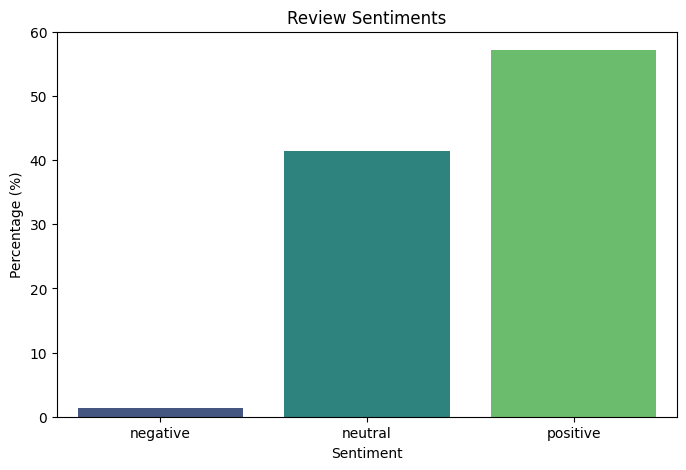

In [39]:
sentiments = sentiment_dist(df)

### Tuning the sentiment boundaries
The results above find very few negative reviews with the arbitrarily set boundaries pos and neg used in the sentiment classification. Let's review the sentiment distribution and consider if there may be more appropriate values for pos and neg.

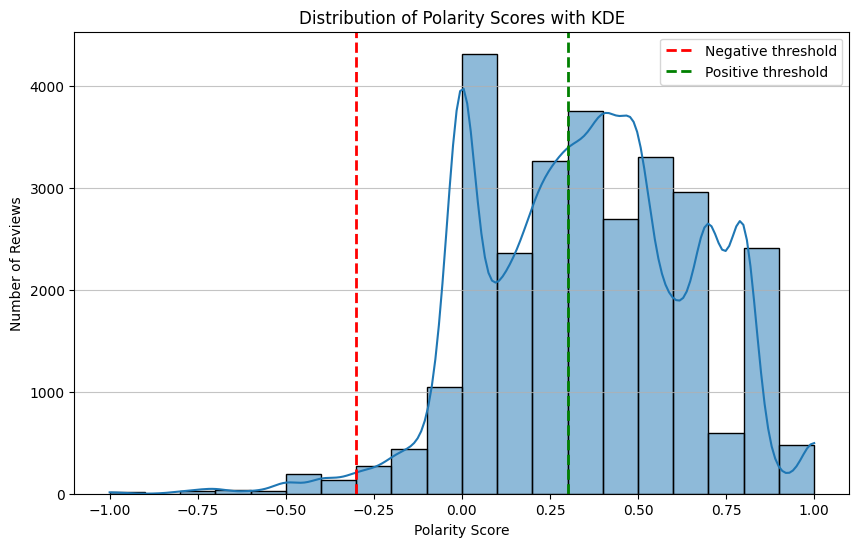

In [40]:
plot_polarity(df)

On the plot above the boundaries are shown as vertical lines. Reviews with polarity scores to the left of the red line, the negative threshold, are assigned as negative sentiment. Reviews with polarity scores to the right of the green line, the positive threshold, are assigned as positive sentiment. Reviews with polarity scores between the red and green lines, are assigned as neutral sentiment.

The polarity distribution is strongly skewed towards values greater than 0, towards neutral and positive sentiment. There is a discontinuity in the distribution at polarity = 0, suggesting a meaningful value for neg could be 0 and pos could be increased to 0.4 or 0.5.

However, this is still somewhat arbitrary and it isn't necessary to have an equal distribution of sentiments for this analysis. This classification could be interpretted as "the products are doing fine", however, that is unlikely to meet business goals for improving quality, customer satisfaction and repeat purchases.

The Net Promoter Score (NPS) metric is used to analyse customer satisfaction as a single number. It is the dominant metric used in marketing and consumer analysis.

In NPS, a customer is asked to rate how likely they are to recommend the product/service/experience on a scale of 0-10. Scores of 9 and 10 are considered promoters, 7 and 8 are passives and 0-6 are detractors. Then NPS = promoters - detractors expressed as a percentage of the surveyed population.

I will take inspiration from the NPS metric to set pos and neg. On the NPS scale [0, 10], pos = 9 and neg = 6. Translating this to the polarity scale [-1, 1] gives pos = 0.8 and neg = 0.2.

References:
* https://en.wikipedia.org/wiki/Net_promoter_score
* https://www.qualtrics.com/articles/customer-experience/good-net-promoter-score/

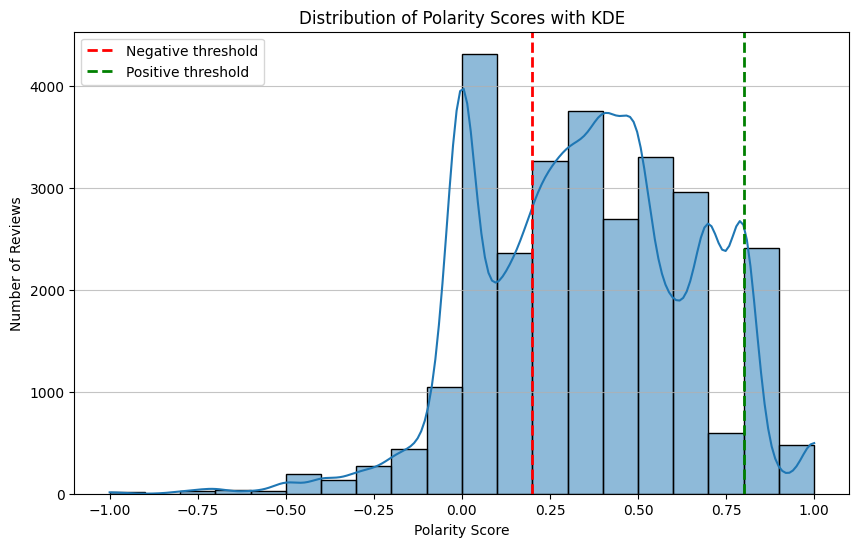

In [41]:
# Replot the polarity distribution with the new boundaries
plot_polarity(df, pos=0.8, neg=0.2)

It is now clear that the class of positive sentiment will be greatly reduced. This is expected as NPS is known to be a tough measure:

>  **Negative NPS (<0):** Indicates that a company has more detractors than promoters, signalling potential issues with customer satisfaction.  
**Positive NPS (0-30):** This range is considered average. It indicates a relatively balanced level of satisfaction with more promoters than detractors but also a significant number of passive or detractor customers.  
**Good NPS (30-50):** Scores in this range are generally seen as good, showing that a company has a strong base of promoters who are likely to recommend the product or service.  
**Excellent NPS (50-70):** Scores in this range are excellent. They indicate high customer loyalty and satisfaction, with a large proportion of customers being promoters.  
**World-Class NPS (>70):** Scores above 70 are exceptional and indicate a very high level of customer satisfaction and loyalty. Companies with such scores are typically leaders in their industry.  

Note: the NPS score lies on the interval [-100, 100].

Further assessments of leading business-to-consumer (B2C) retailers, typically find only a handful of businesses achieving an excellent or world-class NPS score.

Since I've chosen to use the NPS methodology as the inspiration for my sentiment classification boundaries, it is to be expected that applying the same thresholds is similarly harsh, but also highlights true excellence.

References:
* https://viewpoint-research.co.uk/our-blog-podcasts/what-is-a-good-net-promoter-score

* https://customergauge.com/benchmarks/blog/consumer-nps-benchmarks

In [42]:
# Reanalyse the complete dataset with the new boundaries
result2 = review_sentiment(df, pos=0.8, neg=0.2)

,name,brand,category,reviews,text,polarity,sentiment
12472,Amazon Tap Smart Assistant Alexaenabled (black) Brand New,Amazon,Electronics,I purchased this for my son's birthday.. he loved it..,purchase son birthday love,0.500000,neutral
4838,AmazonBasics AAA Performance Alkaline Batteries (36 Count),AmazonBasics,Health & Beauty,"For the price, one really cannot complain. It's a shame that batteries aren't this fairly priced everywhere. Amazon basics does it is again in my opinion. Good overall value.",price complain shame battery fairly price Amazon basic opinion good overall value,0.350000,neutral
2710,AmazonBasics AAA Performance Alkaline Batteries (36 Count),AmazonBasics,Health & Beauty,Great value. Will order again.,great value order,0.800000,neutral
5934,AmazonBasics AAA Performance Alkaline Batteries (36 Count),AmazonBasics,Health & Beauty,I have to admit I was not too happy with these and probably won't buy them again. The 'life' on them is extremely short and definitely leave a lot to be desired.,admit happy probably buy life extremely short definitely leave lot desire,0.266667,neutral
16150,"Fire Kids Edition Tablet, 7 Display, Wi-Fi, 16 GB, Pink Kid-Proof Case",Amazon,Toys & Games,This is great product. The tablet are made tough and great price.,great product tablet tough great price,0.403704,neutral
10122,AmazonBasics AA Performance Alkaline Batteries (48 Count) - Packaging May Vary,AmazonBasics,Health & Beauty,Works great with wireless mics.,work great wireless mic,0.800000,neutral
2493,AmazonBasics AAA Performance Alkaline Batteries (36 Count),AmazonBasics,Health & Beauty,Great price.,great price,0.800000,neutral
1045,AmazonBasics AAA Performance Alkaline Batteries (36 Count),AmazonBasics,Health & Beauty,Does not last as long as name brands such as Duracell and Energizer.,long brand Duracell Energizer,-0.050000,negative
22541,"Fire Tablet with Alexa, 7 Display, 16 GB, Blue - with Special Offers",Amazon,Electronics,i mainly purchased this so my child can have access to amazon undergrond to get free apps. he normally uses an ipad . i can tell this is slower but i was not looking for ipad quality. it gets the job done,mainly purchase child access amazon undergrond free app normally use ipad tell slow look ipad quality get job,0.104167,negative
20745,"All-New Fire HD 8 Kids Edition Tablet, 8 HD Display, 32 GB, Pink Kid-Proof Case",Amazon,Electronics,Great for kids. Tons of content available. Perfect for learning and long car rides.,great kid ton content available perfect learning long car ride,0.537500,neutral


In [43]:
# Save the updated DataFrame to a new CSV file
if colab:
    df.to_csv(
        "/content/drive/MyDrive/Colab Notebooks/review2 sentiments.csv",
        index=False
    )

else:
    df.to_csv("review2 sentiments.csv", index=False)

Percentage Distribution:
sentiment
negative    30.389665
neutral     67.076098
positive     2.534237
Name: count, dtype: float64


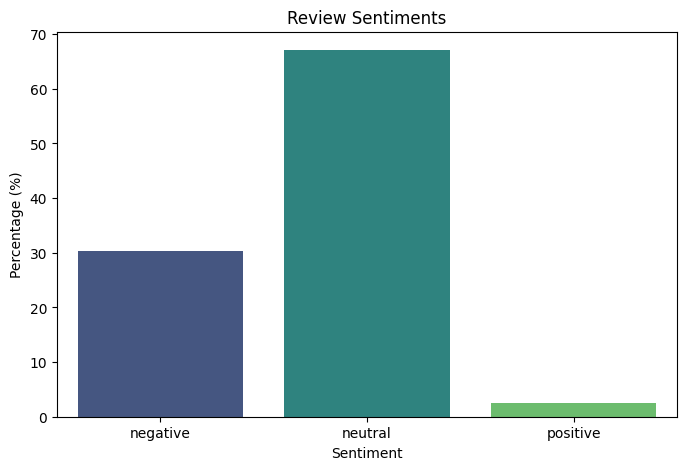

In [44]:
# Plot the sentiment distribution with the new boundaries
sentiments = sentiment_dist(df)

The NPS metric is known to be harsh, and to drive performance towards excellence. In that context the domination of neutral comments is both encouraging about current performance but motivational for future improvements.

### Brand analysis

In [45]:
# Polarity scores by brand
brand_polarity_scores = df.groupby('brand')['polarity'].describe()
brand_polarity_scores

,count,mean,std,min,25%,50%,75%,max
brand,,,,,,,,
Amazon,16153.0,0.358864,0.256726,-0.8,0.2,0.367424,0.5,1.0
AmazonBasics,12179.0,0.353129,0.346682,-1.0,0.0,0.350000,0.7,1.0


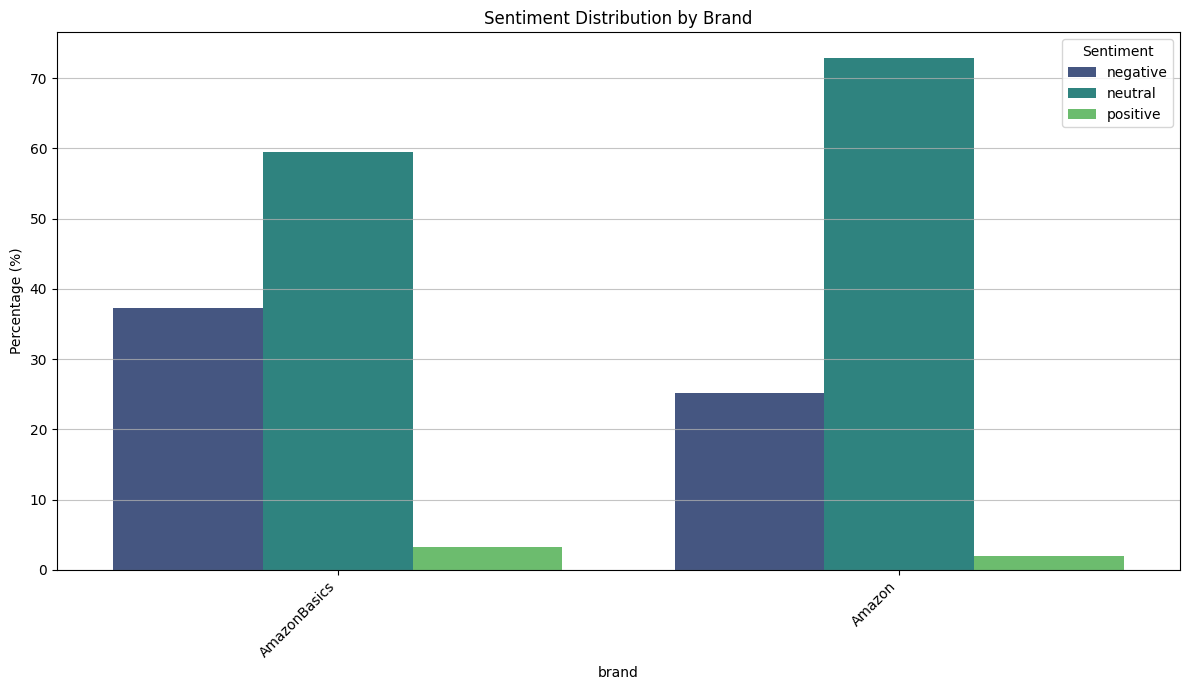

In [46]:
plot_sentiment_distribution(df, 'brand', title='Sentiment Distribution by Brand')

The proportion of neutral and positive reviews for Amazon is higher than for AmazonBasics overall, but the proportion of positive reviews is higher for AmazonBasics. This may be due to different consumer expectations of economy brand products. 

### Category analysis

In [47]:
# Polarity scores by category
cat_polarity_scores = df.groupby('category')['polarity'].describe()
cat_polarity_scores

,count,mean,std,min,25%,50%,75%,max
category,,,,,,,,
Animals & Pet Supplies,6.0,0.516820,0.226423,0.191071,0.424053,0.470833,0.687500,0.8
Electronics,14182.0,0.360741,0.258326,-0.800000,0.200000,0.372222,0.508333,1.0
Health & Beauty,12071.0,0.353749,0.347163,-1.000000,0.000000,0.350000,0.700000,1.0
Home & Garden,2.0,0.250000,0.353553,0.000000,0.125000,0.250000,0.375000,0.5
Office Supplies,395.0,0.342768,0.257702,-0.750000,0.198889,0.344444,0.500000,1.0
Toys & Games,1676.0,0.341502,0.244188,-0.666667,0.188542,0.350000,0.500000,1.0


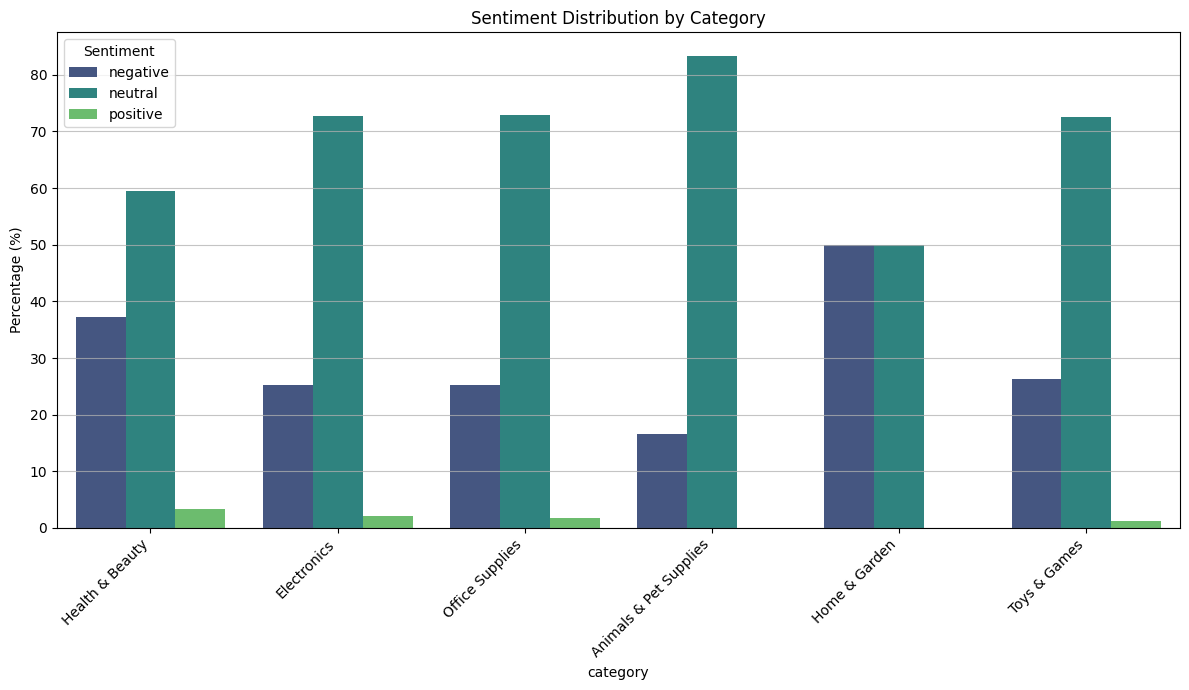

In [48]:
plot_sentiment_distribution(
    df, 'category', title='Sentiment Distribution by Category'
    )

The health & beauty category has the highest proportions of both negative and positive reviews, while electronics has the highest proportion of neutral reviews (neglecting animals & pet supplies due to small sample size). The polarity distribution within the health & beauty category is broader than for electronics with an interquartile range over three times larger. 

While working with a test set of the first 100 rows, I noticed that all the health & beauty product names were batteries. This makes me suspect that a significant portion of the health & beauty reviews are miscategorised.

In [67]:
# Filter for Health & Beauty category
health_beauty = df[df['category'] == 'Health & Beauty']

# Check for 'battery' or 'batteries' (case-insensitive)
contains_battery = health_beauty['name'].str.lower().str.contains(
    'battery|batteries', 
    na=False
)
print(
    f"There are {len(contains_battery)} names in the Health & Beauty "
    f"category that contain battery or batteries. There are "
    f"{len(health_beauty)} names in total."
)

There are 10858 names in the Health & Beauty category that contain battery or batteries. There are 10858 names in total.


There is definitely an issue with the Health & Beauty category labels, that I can't resolve. In case there are other issues with these particular reviews, and given there are over 12000 electronics reviews, I will work with the electronics reviews only going forward.

### Similarity analysis

In [60]:
# Find the similarity matrix for positive reviews
similarity_matrix_positive = rev_similarity_by_cat_sent(
    'Electronics', 'positive', df
    )

Similarity calculation complete.


In [61]:
# Find the similarity matrix for negative reviews
similarity_matrix_negative = rev_similarity_by_cat_sent(
    'Electronics', 'negative', df
    )

Similarity calculation complete.


Semantic Closeness: Each cell in the matrix represents the cosine similarity between two specific reviews. A value closer to 1.0 indicates that the two reviews are very similar in their semantic content and phrasing, while a value closer to 0.0 suggests they are quite different.

Identifying Common Themes: If you observe clusters of reviews with consistently high similarity scores (e.g., a group of reviews all mentioning 'excellent battery life' or 'fast performance'), this suggests prevalent positive themes within that category. These commonalities highlight key strengths of the products that resonate with customers.

Spotting Redundancy or Consensus: High similarity scores could also point to a high degree of consensus among reviewers about certain product attributes. In some cases, very high scores might even indicate similar phrasing.

Understanding Diversity: Conversely, reviews that show low similarity scores, even within the same 'positive' sentiment, indicate diverse reasons for satisfaction. Some customers might praise the design, others the functionality, and yet others the customer service. This diversity helps understand the full spectrum of positive user experience.

In essence, the similarity_matrix transforms qualitative review text into a measurable, comparable format, allowing us to dig deeper than just a simple positive/negative/neutral label to understand why reviews have a certain sentiment and what aspects of the product are consistently mentioned.

### Cluster Analysis
Prepare the `similarity_matrix` for clustering by converting it into a distance matrix (e.g., using `1 - similarity`).

In [63]:
distance_matrix_positive =  distance_matrix(similarity_matrix_positive)
distance_matrix_negative = distance_matrix(similarity_matrix_negative)


Apply a hierarchical clustering algorithm to group reviews based on their calculated distances. First view the dendrogram to determine an appropriate number of clusters.


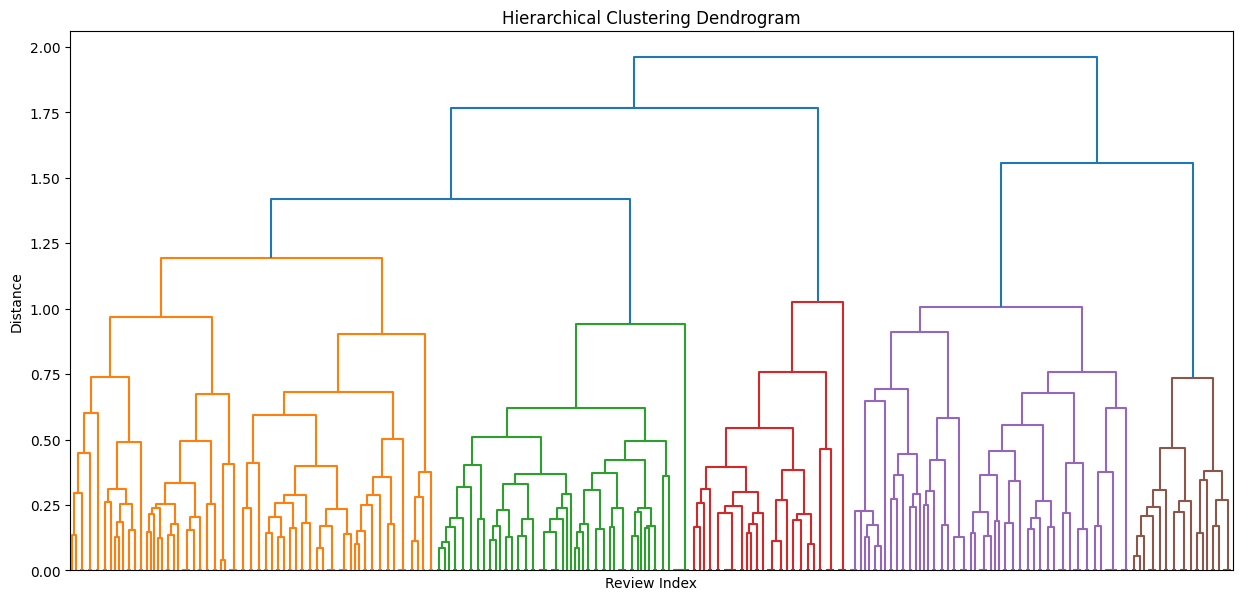

In [64]:
# Check dendrogram for positive reviews
Z_positive = display_dendrogram(distance_matrix_positive)

The dendrogram indicates 3 clusters would be appropriate for the positive sentiments.

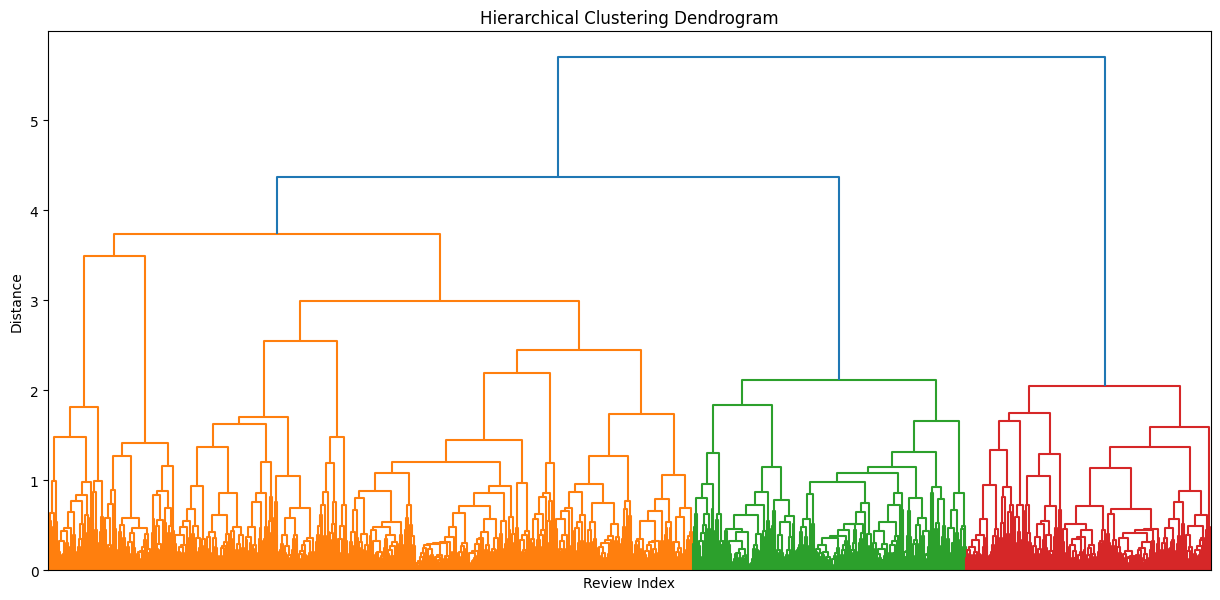

In [67]:
# Check dendrogram for negative reviews
Z_negative = display_dendrogram(distance_matrix_negative)

The dendrogram indicates 3 clusters would be appropriate for the negative sentiments.

In [68]:
# Set number of clusters
num_clusters = 3

In [76]:
# Perform clustering on positive reviews
cluster_df_positive = cluster_analysis(
    distance_matrix_positive, Z_positive, num_clusters
)

Reviews clustered into 3 groups:


,review,cluster
0,Pros: I WOULD recommend anyone who was going t...,3
1,I am a Verizon Technician and this laptop case...,1
2,"I liked this item for the price,quality and us...",3
3,Best kindle charger ever. Took 30 minutes to b...,2
4,Best speaker with Alexa enabled. Value of money!!,3


Cluster distribution:


,count
cluster,
3,158
1,98
2,40


In [77]:
# Perform clustering on negative reviews
cluster_df_negative = cluster_analysis(
    distance_matrix_negative, Z_negative, num_clusters
)

Reviews clustered into 3 groups:


,review,cluster
0,After discarding and getting rid of broken cd ...,3
1,"A few dollars more, but I am boycotting amazon",3
2,My initial impression of this was very good. T...,2
3,Pros: Standard Echo. Cons: Older generation Ec...,3
4,Pros: Relatively easy to setup and works quite...,2


Cluster distribution:


,count
cluster,
3,1976
2,838
1,750


### Analyze Clusters for Representative Reviews
Examine the formed clusters. For each cluster, identify its characteristics and determine a 'representative' review that best exemplifies the common themes within that cluster. The representative review is defined as having the maximum average similarity score with other reviews in the cluster.


In [81]:
# Find representative reviews for the positive reviews
avg_similarities_positive = find_representative_reviews(
    cluster_df_positive, similarity_matrix_positive
    )


--- Cluster Analysis ---

Cluster 1: 98 reviews
  Representative Review (Avg Sim: 0.775):
    'Awesome product, great battery life! I will say this is the best tablet for this awesome price!'

Cluster 2: 40 reviews
  Representative Review (Avg Sim: 0.788):
    'Was looking for tablet to read books and this is perfect for that.'

Cluster 3: 158 reviews
  Representative Review (Avg Sim: 0.794):
    'Great product at a great price from Best Buy. Have to press a button rather than just saying her name, but that's the price you pay for it being cordless.'

--- End Cluster Analysis ---


In [82]:
# Find representative reviews for the negative reviews
avg_similarities_negative = find_representative_reviews(
    cluster_df_negative, similarity_matrix_negative
    )


--- Cluster Analysis ---

Cluster 1: 750 reviews
  Representative Review (Avg Sim: 0.853):
    'Like a lot of reviewers here, I struggled to find the right Bluetooth keyboard to go with my Kindle Fire HD. In the end, I decided to go with the Amazon one, figuring that because Amazon made the Fire and the keyboard, there would be fewer potential problems. At first, this was a good theory. I opened the keyboard as soon as it arrived and paired it immediately to my Kindle Fire HD. There were no problems and it worked perfectly.At first.Unfortunately for me, the next time I worked with the keyboard, I was on a plane trip. I decided to get some writing done (I write novels in my free time) and fired up the keyboard and the Fire. But this time, the keyboard wouldn't pair. At all. The Fire SAID the Keyboard could be paired -- it remembered they had been paired before -- but it just wouldn't pair it. I tried everything I could think of, including pressing the connect button on the keyboard sev

These results suggest that negative reviews are significantly longer than positive reviews. This could be a "short-cut" for future analysis.



In [88]:
# Analyse review length for positive reviews
positive_reviews_with_lengths = analyze_review_lengths(
    cluster_df_positive.copy(), 'Positive', 'green'
    )

# Analyse review length for negative reviews
negative_reviews_with_lengths = analyze_review_lengths(
    cluster_df_negative.copy(), 'Negative', 'red'
    )


Descriptive statistics for Positive review word lengths:
count    296.000000
mean      18.513514
std       11.471105
min        7.000000
25%       11.000000
50%       15.000000
75%       21.000000
max       73.000000
Name: word_count, dtype: float64

Descriptive statistics for Negative review word lengths:
count    3564.000000
mean       39.432660
std        69.551804
min         1.000000
25%        15.000000
50%        24.000000
75%        43.000000
max      1539.000000
Name: word_count, dtype: float64


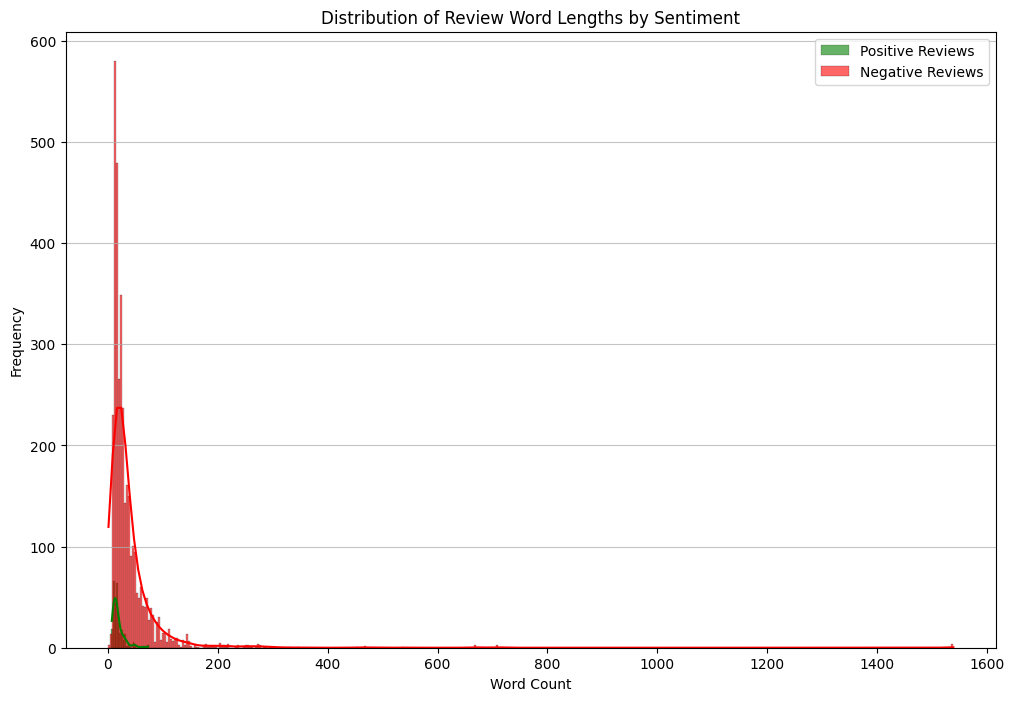

In [90]:
# Prepare figure
figure = plt.figure(figsize=(12,8))

# Plot overlaid histograms
sns.histplot(
    positive_reviews_with_lengths['word_count'],
    color='green', label='Positive Reviews', kde=True, alpha=0.6,
    binrange=(0, max(
        positive_reviews_with_lengths['word_count'].max(),
        negative_reviews_with_lengths['word_count'].max()
        )
    )
)
sns.histplot(
    negative_reviews_with_lengths['word_count'],
    color='red', label='Negative Reviews', kde=True, alpha=0.6,
    binrange=(0, max(
        positive_reviews_with_lengths['word_count'].max(),
        negative_reviews_with_lengths['word_count'].max()
        )
    )
)

# Add labels and title
plt.title('Distribution of Review Word Lengths by Sentiment')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.legend()
plt.grid(axis='y', alpha=0.75)

# Display the plot
plt.show()